In [1]:
import numpy as np
import genesis as gs
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as R

from quadcopter_control.controller import QuadcopterController
from tqdm import tqdm

[I 06/02/25 17:21:43.579 454005] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [10]:
# Sim Constants

DT_S = 1. / 60

DRONE_MASS = 0.027
NEWTON_TO_RPM = 14468.429183500699 / (9.81 * DRONE_MASS / 4)

Ixx = 1.4e-5
Iyy = 1.4e-5
Izz = 2.17e-5

MIN_THRUST = 0.26477955 / 4 * 0.8
MAX_THRUST = 0.26477955 / 4 * 1.5

In [3]:
# Initialize Genesis

gs.init(backend=gs.gpu, logging_level="error")

viewer_options = gs.options.ViewerOptions(
    camera_pos=(2.5, 0.0, 1.5),
    camera_lookat=(0.0, 0.0, 0.5),
    camera_fov=30,
    max_FPS=600,
)

scene = gs.Scene(
    sim_options=gs.options.SimOptions(
        dt=DT_S,
    ),
    viewer_options=viewer_options,
    show_viewer=True,
)

plane = scene.add_entity(
    gs.morphs.Plane(),
)

drone = scene.add_entity(
    morph=gs.morphs.Drone(
        file="urdf/drones/cf2x.urdf",
        pos=(0.0, 0, 0.02),
    ),
)

scene.build()

In [11]:
def reset():
    drone.set_pos(np.array([0, 0, 0.02]), zero_velocity=True)
    drone.set_quat(np.array([1, 0, 0, 0]), zero_velocity=True)
    drone.zero_all_dofs_velocity()
    scene.step(update_visualizer=False)

In [21]:
def sim_step(motors):
    # change motor order
    motors = np.array([motors[0], motors[2], motors[3], motors[1]])

    # scale
    motors = motors * NEWTON_TO_RPM

    drone.set_propellels_rpm(motors)
    scene.step()

    position = drone.get_pos().cpu().numpy()
    velocity = drone.get_vel().cpu().numpy()
    attitude = R.from_quat(drone.get_quat().cpu().numpy(), scalar_first=True)
    omega    = drone.get_ang().cpu().numpy()

    omega[0], omega[1], omega[2] = -omega[0], -omega[1], omega[2]

    return {
        'position': position,
        'velocity': velocity,
        'attitude': attitude,
        'omega': omega
    }

In [13]:
quadcopter_controller = QuadcopterController(
    DT_S,
    DRONE_MASS * 0.99,
    Ixx, Iyy, Izz,
    max_tilt_angle=0.7,
    max_ascent_rate=5.0,
    max_vel_xy=12,
    max_accel_xy=1,
    l=0.03,
    min_motor_thrust=MIN_THRUST, 
    max_motor_thrust=MAX_THRUST,
)

In [14]:
def tune_controller(
        target={
            "position": np.array([0, 0, 5]),
            "velocity": np.zeros(3),
            "acceleration": np.zeros(3),
            "attitude": R.from_quat([0, 0, 0, 1]),
        },
        kp_pqr=np.array([95.0, 95.0, 6.0]),
        kp_bank=0.0,
        kp_pos_z=0.0,
        kp_vel_z=0.0,
        ki_pos_z=0.0,
        kp_pos_xy=0.0,
        kp_yaw=0.0,
        kp_vel_xy=0.0,
        kappa=1.0,
        n_episodes=500,
):
    reset()

    quadcopter_controller.integrated_altitude_error = 0.0
    quadcopter_controller.set_gains(
        kp_pqr=kp_pqr,
        kp_bank=kp_bank,
        kp_pos_z=kp_pos_z,
        kp_vel_z=kp_vel_z,
        ki_pos_z=ki_pos_z,
        kp_pos_xy=kp_pos_xy,
        kp_yaw=kp_yaw,
        kp_vel_xy=kp_vel_xy,
        kappa=kappa
    )

    times = []
    positions = []
    attitudes = []
    motors_ = []
    omegas = []
    velocities = []

    state = sim_step([0, 0, 0, 0])

    t = 0
    for i in tqdm(range(n_episodes)):

        motors = quadcopter_controller.run_control(
            target['position'],
            target['velocity'],
            target['acceleration'],
            target['attitude'],
            state['position'],
            state['velocity'],
            state['omega'],
            state['attitude'],
        )
        motors_.append(motors)

        # accelerations.append(state['acceleration'])
        attitudes.append(state['attitude'].as_quat())
        positions.append(state['position'])
        omegas.append(state['omega'])
        velocities.append(state['velocity'])
        times.append(t)
        state = sim_step(motors)

        t += DT_S

    return (
        np.array(times),
        np.array(positions),
        np.array(velocities),
        np.array(attitudes),
        np.array(omegas),
        np.array(motors_)
    )

In [18]:
reset()
target = {
    "position": np.array([-5, 3, 10]),
    "velocity": np.zeros(3),
    "acceleration": np.zeros(3),
    "attitude": R.from_quat([0, 0, 0, 1]),
}

In [22]:
(times, positions, velocities, attitudes, omegas, motors) =  tune_controller(
    kp_pqr=np.array([25, 25, 5]),
    ki_pos_z=2,
    kp_pos_z=6,
    kp_vel_z=12,
    kp_pos_xy=8.0,
    kp_vel_xy=8.0,
    kp_yaw=1.0,
    kp_bank=2.0,
    n_episodes=3000,
    target=target
)

100%|██████████| 3000/3000 [00:10<00:00, 278.34it/s]


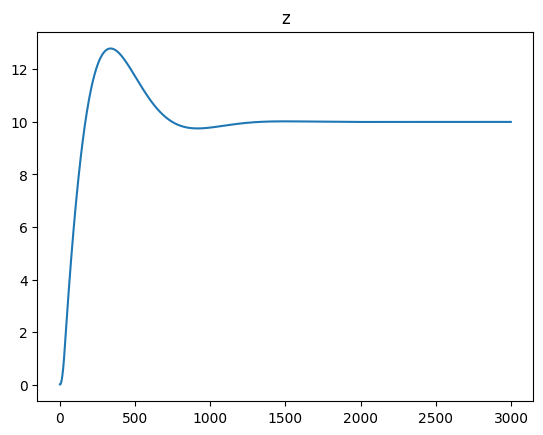

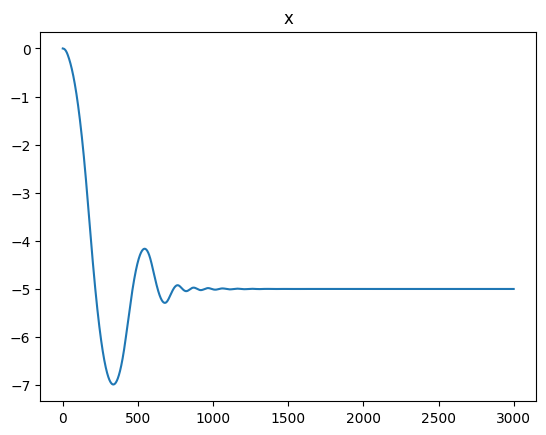

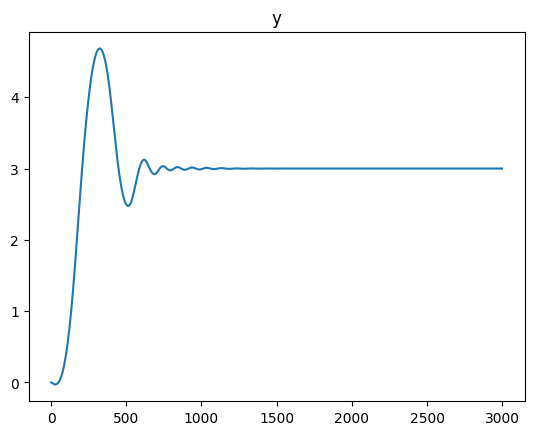

In [23]:
plt.title("z")
plt.plot(positions[:, 2])
plt.show()

plt.title("x")
plt.plot(positions[:, 0])
plt.show()

plt.title("y")
plt.plot(positions[:, 1])
plt.show()